# 2A.ml - Analyse de sentiments - correction

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) où on utilise la fonction ``load_sentiment_dataset``.

In [3]:
from ensae_teaching_cs.data import load_sentiment_dataset
df = load_sentiment_dataset()
df.head()

,sentance,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*. On s'occupe des variables catégorielles.

### La variable catégorielle

Ce serait un peu plus simple avec le module [Category Encoders](http://contrib.scikit-learn.org/categorical-encoding/) ou la dernière nouveauté de scikit-learn : [ColumnTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer).

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                df.drop("sentiment", axis=1), df["sentiment"])

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
le.fit(X_train["source"])
X_le = le.transform(X_train["source"])
X_le.shape

(2250,)

In [6]:
X_le_mat = X_le.reshape((X_le.shape[0], 1))

In [7]:
ohe = OneHotEncoder(categories="auto")
ohe.fit(X_le_mat)

OneHotEncoder()

In [8]:
X_le_encoded = ohe.transform(X_le_mat)
train_cat = X_le_encoded.todense()
test_cat = ohe.transform(le.transform(X_test["source"]).reshape((len(X_test), 1))).todense()

In [9]:
import pandas
X_train2 = pandas.concat([X_train.reset_index(drop=True),
                          pandas.DataFrame(train_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_train2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,Now we were chosen to be tortured with this di...,imdb_labelled,0.0,1.0,0.0
1,"Woa, talk about awful.",imdb_labelled,0.0,1.0,0.0


In [10]:
X_test2 = pandas.concat([X_test.reset_index(drop=True),
                         pandas.DataFrame(test_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_test2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,It looks very nice.,amazon_cells_labelled,1.0,0.0,0.0
1,"As a European, the movie is a nice throwback t...",imdb_labelled,0.0,1.0,0.0


### tokenisation

On tokenise avec le module [spacy](https://spacy.io/usage/spacy-101#annotations-token) qui requiert des données supplémentaires pour découper en mot avec ``pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz`` selon les instructions dévoilées dans le [guide de départ](https://spacy.io/usage/models) ou encore ``python -m spacy download en``. Le module [gensim](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/artificiel_tokenize.html?highlight=tokenisation#gensim) ne requiert pas d'installation. On peut aussi s'inspirer de l'example [word2vec pré-entraînés](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html#word2vec-pre-entraines).

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Ca marche après avoir installé le corpus correspondant
# python -m spacy download en_core_web_sm

In [12]:
doc = nlp(X_train2.iloc[0,0])
[token.text for token in doc]

['Now',
 'we',
 'were',
 'chosen',
 'to',
 'be',
 'tortured',
 'with',
 'this',
 'disgusting',
 'piece',
 'of',
 'blatant',
 'American',
 'propaganda',
 '.',
 ' ']

### tf-idf

Une fois que les mots sont tokenisé, on peut appliquer le *tf-idf*.

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
tokenizer = lambda text: [token.text.lower() for token in nlp(text)]
count = CountVectorizer(tokenizer=tokenizer, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [14]:
pipe.fit(X_train["sentance"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<function <lambda> at 0x000001DCC8835488>)),
                ('tfidftransformer', TfidfTransformer())])

In [15]:
train_feature = pipe.transform(X_train2["sentance"])
train_feature

<2250x4495 sparse matrix of type '<class 'numpy.float64'>'
	with 29554 stored elements in Compressed Sparse Row format>

In [16]:
test_feature = pipe.transform(X_test2["sentance"])

### Combinaison de toutes les variables

In [17]:
train_feature.shape, train_cat.shape

((2250, 4495), (2250, 3))

In [18]:
import numpy
np_train = numpy.hstack([train_feature.todense(), train_cat])
np_test = numpy.hstack([test_feature.todense(), test_cat])

### Calage d'un modèle

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(np_train, y_train)

RandomForestClassifier(n_estimators=50)

In [20]:
rf.score(np_test, y_test)

0.7533333333333333

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity). Avec [spacy](https://spacy.io/usage/vectors-similarity), c'est assez simple :

In [22]:
vv = nlp(X_train2.iloc[0, 0])
list(vv)[0].vector[:10], vv.vector.shape

(array([-0.21269655, -0.7653725 , -0.1316224 , -0.3766306 ,  0.5549566 ,
        -0.60907495,  5.3928123 ,  5.099738  ,  4.210167  ,  2.9974651 ],
       dtype=float32),
 (96,))

On fait la somme.

In [23]:
sum([_.vector for _ in vv])[:10]

array([-11.796999 ,  -8.17019  ,   3.1232045, -14.440253 ,  20.460987 ,
        -8.738287 ,  12.388309 ,  23.718775 ,  -9.392727 ,   1.9914403],
      dtype=float32)

In [24]:
np_train_vect = numpy.zeros((X_train2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_train2["sentance"]):
    np_train_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [25]:
np_test_vect = numpy.zeros((X_test2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_test2["sentance"]):
    np_test_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [26]:
np_train_v = numpy.hstack([np_train_vect, train_cat])
np_test_v = numpy.hstack([np_test_vect, test_cat])

In [27]:
rfv = RandomForestClassifier(n_estimators=50)
rfv.fit(np_train_v, y_train)

RandomForestClassifier(n_estimators=50)

In [28]:
rfv.score(np_test_v, y_test)

0.6146666666666667

Moins bien...

## Exercice 3 : comparer les deux approches

Avec une courbe [ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) par exemple.

In [29]:
pmodel1 = rf.predict_proba(np_test)[:, 1]
pmodel2 = rfv.predict_proba(np_test_v)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr1, tpr1, th1 = roc_curve(y_test, pmodel1)
fpr2, tpr2, th2 = roc_curve(y_test, pmodel2)

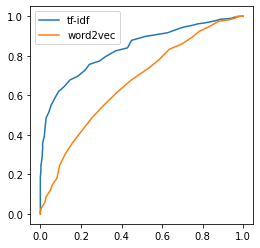

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='tf-idf')
ax.plot(fpr2, tpr2, label='word2vec')
ax.legend();

## Petite analyse d'erreurs

On combine les erreurs des modèles sur la base de test.

In [32]:
final = X_test.copy()
final["model1"] = pmodel1
final["model2"] = pmodel2
final["label"] = y_test
final.head()

,sentance,source,model1,model2,label
850,It looks very nice.,amazon_cells_labelled,0.62,0.62,1
415,"As a European, the movie is a nice throwback t...",imdb_labelled,0.68,0.54,1
585,Great food and great service in a clean and fr...,yelp_labelled,0.94,0.78,1
785,This allows the possibility of double booking ...,amazon_cells_labelled,0.48,0.54,0
440,Both do good jobs and are quite amusing.,imdb_labelled,0.64,0.46,1


On regarde des erreurs.

In [33]:
erreurs = final[final["label"] == 1].sort_values("model2")
erreurs.head()

,sentance,source,model1,model2,label
527,"Be sure to order dessert, even if you need to ...",yelp_labelled,0.54,0.20,1
707,This is cool because most cases are just open ...,amazon_cells_labelled,0.38,0.22,1
449,"I won't say any more - I don't like spoilers, ...",imdb_labelled,0.20,0.22,1
676,I can't wait to go back.,yelp_labelled,0.20,0.22,1
908,"I can hear while I'm driving in the car, and u...",amazon_cells_labelled,0.34,0.24,1


In [34]:
list(erreurs["sentance"])[:5]

['Be sure to order dessert, even if you need to pack it to-go - the tiramisu and cannoli are both to die for.',
 'This is cool because most cases are just open there allowing the screen to get all scratched up.',
 "I won't say any more - I don't like spoilers, so I don't want to be one, but I believe this film is worth your time.  ",
 "I can't wait to go back.",
 "I can hear while I'm driving in the car, and usually don't even have to put it on it's loudest setting."]

Le modèle 2 reconnaît mal les négations visiblement. On regarde le modèle 1.

In [35]:
erreurs = final[final["label"] == 1].sort_values("model1")
erreurs.head()

,sentance,source,model1,model2,label
436,"The soundtrack wasn't terrible, either.",imdb_labelled,0.06,0.34,1
412,Not too screamy not to masculine but just righ...,imdb_labelled,0.08,0.26,1
161,I was seated immediately.,yelp_labelled,0.10,0.38,1
619,Don't miss it.,imdb_labelled,0.12,0.32,1
448,My 8/10 score is mostly for the plot.,imdb_labelled,0.14,0.48,1


In [36]:
list(erreurs["sentance"])[:5]

["The soundtrack wasn't terrible, either.  ",
 'Not too screamy not to masculine but just right.  ',
 'I was seated immediately.',
 "Don't miss it.  ",
 'My 8/10 score is mostly for the plot.  ']

Idem, voyons là où les modèles sont en désaccords.

In [37]:
final["diff"] = final.model1 - final.model2

In [38]:
erreurs = final[final["label"] == 1].sort_values("diff")
erreurs.head()

,sentance,source,model1,model2,label,diff
390,"If you want healthy authentic or ethic food, t...",yelp_labelled,0.30,0.72,1,-0.42
797,A good quality bargain.. I bought this after I...,amazon_cells_labelled,0.34,0.68,1,-0.34
53,This phone is pretty sturdy and I've never had...,amazon_cells_labelled,0.38,0.72,1,-0.34
691,Shot in the Southern California desert using h...,imdb_labelled,0.36,0.70,1,-0.34
448,My 8/10 score is mostly for the plot.,imdb_labelled,0.14,0.48,1,-0.34


In [39]:
erreurs.tail()

,sentance,source,model1,model2,label,diff
464,The inside is really quite nice and very clean.,yelp_labelled,0.94,0.46,1,0.48
4,The mic is great.,amazon_cells_labelled,0.90,0.42,1,0.48
68,Great for iPODs too.,amazon_cells_labelled,0.96,0.46,1,0.50
341,It is a really good show to watch.,imdb_labelled,0.84,0.32,1,0.52
306,Has been working great.,amazon_cells_labelled,0.90,0.32,1,0.58


Le modèle 2 (word2vec) a l'air meilleur sur les phrases longues, le modèle 1 (tf-idf) saisit mieux les mots positifs. A confirmer sur plus de données. 

* Enlever les stop words, les signes de ponctuation.
* Combiner les deux approches.
* n-grammes
* ...

Dernière analyse en regardant le taux d'erreur par source.

In [40]:
r1 = rf.predict(np_test)
r2 = rfv.predict(np_test_v)
final["rep1"] = r1
final["rep2"] = r2
final["err1"] = (final.label - final.rep1).abs()
final["err2"] = (final.label - final.rep2).abs()
final["total"] = 1
final.head()

,sentance,source,model1,model2,label,diff,rep1,rep2,err1,err2,total
850,It looks very nice.,amazon_cells_labelled,0.62,0.62,1,0.00,1,1,0,0,1
415,"As a European, the movie is a nice throwback t...",imdb_labelled,0.68,0.54,1,0.14,1,1,0,0,1
585,Great food and great service in a clean and fr...,yelp_labelled,0.94,0.78,1,0.16,1,1,0,0,1
785,This allows the possibility of double booking ...,amazon_cells_labelled,0.48,0.54,0,-0.06,0,1,0,1,1
440,Both do good jobs and are quite amusing.,imdb_labelled,0.64,0.46,1,0.18,1,0,0,1,1


In [41]:
final[["source", "err1", "err2", "total"]].groupby("source").sum()

,err1,err2,total
source,,,
amazon_cells_labelled,56,94,250
imdb_labelled,77,107,253
yelp_labelled,52,88,247


*imdb* paraît une source une peu plus difficile à saisir. Quoiqu'il en soit, 2000 phrases pour apprendre est assez peu pour apprendre.

## Versions utilisées pour ce notebook

[spacy](https://spacy.io/) s'est montré quelque peu fantasques cette année avec quelques erreurs notamment celle-ci :
[ValueError: cymem.cymem.Pool has the wrong size, try recompiling](https://github.com/explosion/spaCy/issues/2852). Voici les versions utilisées...

In [42]:
def version(module, sub=True):
    try:
        ver = getattr(module, '__version__', None)
        if ver is None:
            ver = [_ for _ in os.listdir(os.path.join(module.__file__, '..', '..' if sub else '')) \
                   if module.__name__ in _ and 'dist' in _][-1]
        return ver
    except Exception as e:
        return str(e)

In [43]:
import os
import thinc
print("thinc", version(thinc))
import preshed
print("preshed", version(preshed))
import cymem
print("cymem", version(cymem))
import murmurhash
print("murmurhash", version(murmurhash))
import spacy
print("spacy", spacy.__version__)

import msgpack
print("msgpack", version(msgpack))
import numpy
print("numpy", numpy.__version__)

thinc 7.4.1
preshed preshed-3.0.2.dist-info
cymem cymem-2.0.2.dist-info
murmurhash murmurhash-1.0.2.dist-info
spacy 2.3.2
msgpack msgpack_numpy-0.4.4.3.dist-info
numpy 1.18.1
